In [1]:
import os
import sys
import time
import copy

import numpy as np
import random
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
torch.backends.cudnn.benchmark=True
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as utils

sys.path.append('audio_tagging_functions')
from models import *

C:\Users\Richard\Anaconda3\envs\pytorch-cpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
MODEL_TYPE = "Transfer_Cnn6"
MODEL_PATH = "pretrained_models/Cnn6_mAP=0.343.pth"

LABELS_PATH = "labels/all_data.csv"
DATA_PATH = "audiodata/wav"

# Audio parameters
SR = 14000             # Sample Rate
AUDIO_DURATION = 10    # 10 seconds duration window for all audios

# Model parameters
NB_SPECIES = 13        # Number of classes
LR = 1e-3              # Learning Rate
BATCH_SIZE = 16
EPOCHS = 2

# Misc parameters
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {DEVICE}")

Device: cpu


### Load Data and Initialize DataLoaders

In [3]:
labels_df = pd.read_csv(LABELS_PATH)
labels_df.head()

,fname,iD,length,label
0,audiodata/wav/sturnus_vulgaris/sturnus_vulgari...,548389,59,0
1,audiodata/wav/sturnus_vulgaris/sturnus_vulgari...,546936,32,0
2,audiodata/wav/sturnus_vulgaris/sturnus_vulgari...,546935,65,0
3,audiodata/wav/sturnus_vulgaris/sturnus_vulgari...,543800,36,0
4,audiodata/wav/sturnus_vulgaris/sturnus_vulgari...,542770,44,0


In [4]:
def load_df2array(df):
    """
    Loads and stores arrays, and also returns a dict of missing files.
    """
    nonValidDict = {}
    waveforms_list = []
    ConstantShape = SR * AUDIO_DURATION # Zero-padding
    
    for idx in range(len(df)):
        filename = df['fname'][idx]
        length = df['length'][idx]
        label = df['label'][idx]

        if os.path.isfile(filename):
            waveform = load_waveform2numpy(filename, length, sample_rate=SR)
            length_waveform = len(waveform)

            # Zero-padding
            if length_waveform != ConstantShape:
                waveform = np.pad(waveform, (0, ConstantShape - length_waveform), 'constant')

            waveforms_list.append([waveform, label])

        else:
            iD = df['iD'][idx]
            nonValidDict[iD] = filename

    return waveforms_list, nonValidDict

In [5]:
def load_waveform2numpy(filename, length, sample_rate):
    """
    Loads from filename path and returns numpy array.
    """
    # Random crop of a 10 sec segment
    offset = random.randint(0, length-AUDIO_DURATION)

    waveform, _ = librosa.core.load(filename, sr=sample_rate, mono=True, offset=offset, duration=AUDIO_DURATION)
    #waveform = waveform[None, :]    # (1, audio_length)

    return waveform

In [6]:
%%time
waveforms_list, nonValidDict = load_df2array(labels_df)
print(f"Valid files: {len(waveforms_list)}\nUnvalid files: {len(nonValidDict)}")

Valid files: 6138
Unvalid files: 9
Wall time: 30.8 s


In [7]:
waveforms_arrays = [x[0] for x in waveforms_list]
X_all = np.vstack(waveforms_arrays)
y_all = np.array([x[1] for x in waveforms_list])
print(f"X_all:{X_all.shape}, y_all:{y_all.shape}")

X_all:(6138, 140000), y_all:(6138,)


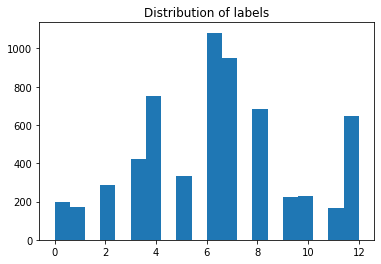

In [8]:
# Plot the distribution of labels
plt.hist(y_all, bins=20)
plt.title("Distribution of labels")
plt.show()

In [9]:
# Split Data in train, validation, test
X_training, X_test, y_training, y_test = train_test_split(X_all, y_all, test_size=0.1, 
                                                          random_state=RANDOM_STATE, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, 
                                                  random_state=RANDOM_STATE, stratify=y_training)
print(f"X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}")
print(f"y_train:{y_train.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}")

X_train:(4419, 140000), X_val:(1105, 140000), X_test:(614, 140000)
y_train:(4419,), y_val:(1105,), y_test:(614,)


In [10]:
def get_dataloaders(x, y):
    tensor_x = torch.from_numpy(x).float().to(DEVICE)
    tensor_y = torch.from_numpy(y).long().to(DEVICE)

    tensordataset = utils.TensorDataset(tensor_x, tensor_y)
    dataloader = utils.DataLoader(tensordataset, batch_size=BATCH_SIZE)

    return dataloader

In [11]:
trainloader = get_dataloaders(X_train, y_train)
validationloader = get_dataloaders(X_val, y_val)
testloader = get_dataloaders(X_test, y_test)

### Load the pretrained model

Inspired by: https://github.com/qiuqiangkong/audioset_tagging_cnn/blob/master/pytorch/finetune_template.py

In [12]:
class Transfer_Cnn6(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn6, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn6(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(512, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path, map_location=torch.device(DEVICE))
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']

        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [13]:
# Model Audio parameters
window_size = 1024
hop_size = 320
mel_bins = 64
fmin = 50
fmax = 14000
freeze_base = True
sample_rate = 14000
classes_num = NB_SPECIES

# Initialize Model
Model = eval(MODEL_TYPE)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, 
    classes_num, freeze_base)

print(model)

# Load pretrained model
model.load_from_pretrain(MODEL_PATH)

# Parallel
print('GPU number: {}'.format(torch.cuda.device_count()))
model = torch.nn.DataParallel(model)

if DEVICE == 'cuda':
    model.to(DEVICE)

print('Load pretrained model successfully!')

C:\Users\Richard\Anaconda3\envs\pytorch-cpu\lib\site-packages\librosa\filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


Transfer_Cnn6(
  (base): Cnn6(
    (spectrogram_extractor): Spectrogram(
      (stft): STFT(
        (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
      )
    )
    (logmel_extractor): LogmelFilterBank()
    (spec_augmenter): SpecAugmentation(
      (time_dropper): DropStripes()
      (freq_dropper): DropStripes()
    )
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock5x5(
      (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock5x5(
      (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block3): Con

### Training Part

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [14]:
dataloaders = {"train": trainloader,
               "val": validationloader}
dataset_sizes = {"train": len(trainloader)*BATCH_SIZE,
                 "val": len(validationloader)*BATCH_SIZE}

In [15]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        lasttime = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)['clipwise_output']
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f">Epoch's duration {time.time() - lasttime} seconds<\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
%%time
trained_model = train_model(model, criterion, optimizer, 
                            exp_lr_scheduler, dataloaders, num_epochs=EPOCHS)

Epoch 0/1
----------
train Loss: 2.4345 Acc: 0.1934
val Loss: 2.0939 Acc: 0.3473
>Epoch's duration 1372.8128345012665 seconds<

Epoch 1/1
----------


KeyboardInterrupt: 